# Sensitivity Analysis with Sensmakr and Debiased ML

## Sensititivy Analysis for Unobserved Confounder with DML and Sensmakr


 Here we experiment with using package "sensemakr" in conjunction with debiased ML

We will 

* mimic the partialling out procedure with machine learning tools, 

* and invoke Sensmakr to compute $\phi^2$ and plot sensitivity results.


We will use the sensemakr package adapted in python (PySensemakr) by Brian Hill and Nathan LaPierre [ink](https://github.com/nlapier2/PySensemakr)

In [1]:
#pip install PySensemakr

In [2]:
#Import packages
import sensemakr as smkr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loads data
darfur = pd.read_csv("../data/darfur.csv")
darfur.shape

(1276, 14)

Data is described here 
https://cran.r-project.org/web/packages/sensemakr/vignettes/sensemakr.html

The main outcome is attitude towards peace -- the peacefactor.
The key variable of interest is whether the responders were directly harmed (directlyharmed).
We want to know if being directly harmed in the conflict causes people to support peace-enforcing measures.
The measured confounders include female indicator, age, farmer, herder, voted in the past, and household size.
There is also a village indicator, which we will treat as fixed effect and partial it out before conducting
the analysis. The standard errors will be clustered at the village level.

## Take out village fixed effects and run basic linear analysis

In [4]:
# get rid of village fixed effects
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
# 1. basic model
peacefactorR = smf.ols('peacefactor~village' , data=darfur).fit().resid
directlyharmedR = smf.ols('directlyharmed~village' , data=darfur).fit().resid
femaleR = smf.ols('female~village' , data=darfur).fit().resid
ageR = smf.ols('age~village' , data=darfur).fit().resid
farmerR = smf.ols('farmer_dar~village' , data=darfur).fit().resid
herderR = smf.ols('herder_dar~village' , data=darfur).fit().resid
pastvotedR = smf.ols('pastvoted~village' , data=darfur).fit().resid
hhsizeR = smf.ols('hhsize_darfur~village' , data=darfur).fit().resid

In [6]:
darfurR = pd.concat([peacefactorR, directlyharmedR, femaleR,
                    ageR, farmerR, herderR, pastvotedR, 
                     hhsizeR, darfur['village']], axis=1)
darfurR.head()

,0,1,2,3,4,5,6,7,village
0,1.310063e-14,5.171073e-14,-1.353145e-13,2.749800e-12,-8.823583e-14,-7.293814e-15,-6.172840e-14,1.431744e-12,Abdel Khair
1,-9.903189e-14,7.581381e-14,7.049916e-14,9.912071e-13,1.043610e-13,2.568140e-14,-4.152234e-14,-1.957545e-12,Abdi Dar
2,-3.029464e-01,-3.333333e-01,-3.333333e-01,6.666667e-01,3.333333e-01,6.646498e-17,-6.666667e-01,4.666667e+00,Abu Sorog
3,3.301185e-01,3.333333e-01,-6.666667e-01,1.733333e+01,-6.666667e-01,-3.333333e-01,-3.333333e-01,1.666667e+00,Abu Dejaj
4,-1.650592e-01,3.333333e-01,3.333333e-01,-1.266667e+01,3.333333e-01,-3.333333e-01,6.666667e-01,-3.333333e-01,Abu Dejaj


In [7]:
darfurR.columns = ["peacefactorR", "directlyharmedR", "femaleR",
                    "ageR", "farmerR", "herderR", "pastvotedR", 
                     "hhsize_darfurR", "village"]
darfurR.head()

,peacefactorR,directlyharmedR,femaleR,ageR,farmerR,herderR,pastvotedR,hhsize_darfurR,village
0,1.310063e-14,5.171073e-14,-1.353145e-13,2.749800e-12,-8.823583e-14,-7.293814e-15,-6.172840e-14,1.431744e-12,Abdel Khair
1,-9.903189e-14,7.581381e-14,7.049916e-14,9.912071e-13,1.043610e-13,2.568140e-14,-4.152234e-14,-1.957545e-12,Abdi Dar
2,-3.029464e-01,-3.333333e-01,-3.333333e-01,6.666667e-01,3.333333e-01,6.646498e-17,-6.666667e-01,4.666667e+00,Abu Sorog
3,3.301185e-01,3.333333e-01,-6.666667e-01,1.733333e+01,-6.666667e-01,-3.333333e-01,-3.333333e-01,1.666667e+00,Abu Dejaj
4,-1.650592e-01,3.333333e-01,3.333333e-01,-1.266667e+01,3.333333e-01,-3.333333e-01,6.666667e-01,-3.333333e-01,Abu Dejaj


In [8]:
# Preliminary linear model analysis 
# Linear model 1 
linear_model_1 = smf.ols('peacefactorR~ directlyharmedR+ femaleR + ageR + farmerR+ herderR + pastvotedR + hhsizeR' 
        ,data=darfurR ).fit().get_robustcov_results(cov_type = "cluster", groups= darfurR['village'])
linear_model_1_table = linear_model_1.summary2().tables[1]
linear_model_1_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-2.538768e-15,2.685827e-15,-0.945246,3.450038e-01,-7.816060e-15,2.738525e-15
directlyharmedR,9.731582e-02,2.382281e-02,4.084985,5.156752e-05,5.050716e-02,1.441245e-01
femaleR,-2.320514e-01,2.443857e-02,-9.495295,1.000143e-19,-2.800700e-01,-1.840329e-01
ageR,-2.071749e-03,7.441260e-04,-2.784137,5.576761e-03,-3.533858e-03,-6.096402e-04
farmerR,-4.044295e-02,2.956411e-02,-1.367974,1.719536e-01,-9.853250e-02,1.764661e-02
herderR,1.427910e-02,3.649802e-02,0.391229,6.957994e-01,-5.743466e-02,8.599286e-02
pastvotedR,-4.802496e-02,2.687661e-02,-1.786868,7.458324e-02,-1.008339e-01,4.784016e-03
hhsizeR,1.229812e-03,2.166312e-03,0.567698,5.705024e-01,-3.026704e-03,5.486328e-03


In [9]:
# Linear model 2 
linear_model_2 = smf.ols('peacefactorR~ femaleR + ageR + farmerR+ herderR + pastvotedR + hhsizeR' 
        ,data=darfurR ).fit().get_robustcov_results(cov_type = "cluster", groups= darfurR['village'])
linear_model_2_table = linear_model_2.summary2().tables[1]
linear_model_2_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-2.465909e-15,2.453072e-15,-1.005233,3.152858e-01,-7.285870e-15,2.354052e-15
femaleR,-2.415042e-01,2.536306e-02,-9.521887,8.063158e-20,-2.913393e-01,-1.916692e-01
ageR,-2.186810e-03,7.453429e-04,-2.933966,3.505173e-03,-3.651310e-03,-7.223106e-04
farmerR,-4.071431e-02,2.923021e-02,-1.392885,1.642928e-01,-9.814780e-02,1.671917e-02
herderR,2.622875e-02,3.967810e-02,0.661038,5.089015e-01,-5.173345e-02,1.041909e-01
pastvotedR,-4.414131e-02,2.784297e-02,-1.585367,1.135348e-01,-9.884904e-02,1.056643e-02
hhsizeR,1.336220e-03,2.126678e-03,0.628314,5.300943e-01,-2.842419e-03,5.514859e-03


In [10]:
# Linear model 3
linear_model_3 = smf.ols('directlyharmedR~ femaleR + ageR + farmerR+ herderR + pastvotedR + hhsizeR' 
        ,data=darfurR ).fit().get_robustcov_results(cov_type = "cluster", groups= darfurR['village'])
linear_model_3_table = linear_model_3.summary2().tables[1]
linear_model_3_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,8.380883e-16,2.459246e-15,0.340791,0.733409,-3.994003e-15,5.670179e-15
femaleR,-9.713517e-02,5.128637e-02,-1.893976,0.058823,-1.979061e-01,3.635740e-03
ageR,-1.182350e-03,1.150680e-03,-1.027523,0.304687,-3.443283e-03,1.078584e-03
farmerR,-2.788538e-03,4.280159e-02,-0.065150,0.948081,-8.688797e-02,8.131090e-02
herderR,1.227925e-01,5.064352e-02,2.424643,0.015688,2.328466e-02,2.223002e-01
pastvotedR,3.990773e-02,3.366253e-02,1.185524,0.236391,-2.623468e-02,1.060501e-01
hhsizeR,1.093431e-03,3.286160e-03,0.332738,0.739476,-5.363437e-03,7.550298e-03


## We first use Lasso for Partilling Out Controls

In [11]:
import hdmpy
import patsy 
from patsy import ModelDesc, Term, EvalFactor

In [12]:

X = patsy.dmatrix("(femaleR + ageR + farmerR+ herderR + pastvotedR + hhsizeR)**3", darfurR)
Y = darfurR['peacefactorR'].to_numpy()
D = darfurR['directlyharmedR'].to_numpy()

In [13]:
resY = hdmpy.rlasso(X,Y, post = False).est['residuals'].reshape( Y.size,)
resD = hdmpy.rlasso(X,D, post = False).est['residuals'].reshape( D.size,)


In [14]:
FVU_Y = 1 - np.var(resY)/np.var(peacefactorR)
FVU_D = 1 - np.var(resD)/np.var(directlyharmedR)

print("Controls explain the following fraction of variance of Outcome", FVU_Y)
print("Controls explain the following fraction of variance of treatment", FVU_D)

Controls explain the following fraction of variance of Outcome 0.12505767421787006
Controls explain the following fraction of variance of treatment 0.011939558050506838


In [15]:
darfurR['resY'] = resY
darfurR['resD'] = resD

In [16]:
# Filan estimation
# Culster SE by village
dml_darfur_model = smf.ols('resY~ resD',data=darfurR ).fit().get_robustcov_results(cov_type = "cluster", groups= darfurR['village'])
dml_darfur_model_table = dml_darfur_model.summary2().tables[1]
dml_darfur_model_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-6.357952e-10,0.000159,-0.000004,0.999997,-0.000312,0.000312
resD,1.003438e-01,0.024429,4.107623,0.000047,0.052345,0.148343


## Manual Bias Analysis

In [17]:
# linear model to use as input in sensemakr   
dml_darfur_model= smf.ols('resY~ resD',data=darfurR ).fit()
dml_darfur_model_table = dml_darfur_model.summary2().tables[1]
dml_darfur_model_table

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,-6.357952e-10,0.006843,-9.291193e-08,9.999999e-01,-0.013425,0.013425
resD,1.003438e-01,0.018273,5.491364e+00,4.809577e-08,0.064495,0.136192


In [18]:
beta = dml_darfur_model_table['Coef.'][1]
beta

0.10034379376801948

0.04020151261036848


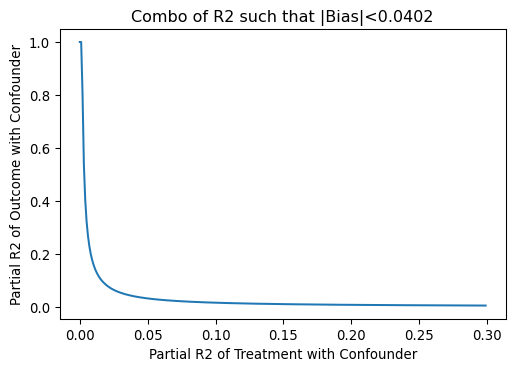

In [19]:
# Hypothetical values of partial R2s 
R2_YC = .16 
R2_DC = .01

# Elements of the formal
kappa = (R2_YC * R2_DC)/(1- R2_DC)
varianceRatio = np.mean(dml_darfur_model.resid**2)/np.mean(dml_darfur_model.resid**2)

# Compute square bias 
BiasSq =  kappa*varianceRatio

# Compute absolute value of the bias
print(np.sqrt(BiasSq))

# plotting 
gridR2_DC = np.arange(0,0.3,0.001)
gridR2_YC =  kappa*(1 - gridR2_DC)/gridR2_DC
gridR2_YC = np.where(gridR2_YC > 1, 1, gridR2_YC)

plt.title("Combo of R2 such that |Bias|<{}".format(round(np.sqrt(BiasSq), 5)))
plt.xlabel("Partial R2 of Treatment with Confounder") 
plt.ylabel("Partial R2 of Outcome with Confounder") 
plt.plot(gridR2_DC,gridR2_YC) 
plt.show()

## Bias Analysis with Sensemakr

In [20]:
# Imports
import sensemakr as smkr
# from sensemakr import sensitivity_stats
# from sensemakr import bias_functions
# from sensemakr import ovb_bounds
# from sensemakr import ovb_plots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

In [21]:
a = 1
b = 3

In [22]:
if a is not None and b is not None:
    print('hola')

hola


In [23]:
import sensemakr as smkr

In [24]:
# We need to double check why the function does not allow to run withour the benchmark_covariates argument
model = smkr.Sensemakr( model = dml_darfur_model, treatment = "resD")

In [25]:
model.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: resY~ resD

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' resD ':
  Coef. estimate: 0.1
  Standard Error: 0.018
  t-value: 5.491 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.023
  Robustness Value, q = 1 : 0.142
  Robustness Value, q = 1 alpha = 0.05 : 0.094 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.312 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Value, q = 1 : unobserved confounders (orthogonal to the covariates) that  explain more than 14.247 % of the resi

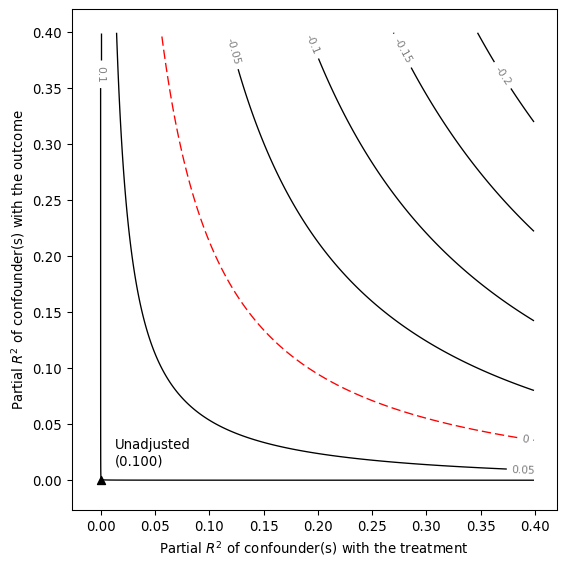

In [26]:
model.plot()

## Next We use Random Forest as ML tool for Partialling Out

The following code does DML with clsutered standard errors by ClusterID

In [27]:
import itertools
from itertools import compress

In [28]:
def DML2_for_PLM(x, d, y, dreg, yreg, nfold, clu):
    
    # Num ob observations
    nobs = x.shape[0]
    
    # Define folds indices 
    list_1 = [*range(0, nfold, 1)]*nobs
    sample = np.random.choice(nobs,nobs, replace=False).tolist()
    foldid = [list_1[index] for index in sample]

    # Create split function(similar to R)
    def split(z, f):
        count = max(f) + 1
        return tuple( list(itertools.compress(z, (el == i for el in f))) for i in range(count) ) 

    # Split observation indices into folds 
    list_2 = [*range(0, nobs, 1)]
    I = split(list_2, foldid)
    
    # loop to save results
    for b in range(0,len(I)):
    
        # Split data - index to keep are in mask as booleans
        include_idx = set(I[b])  #Here should go I[b] Set is more efficient, but doesn't reorder your elements if that is desireable
        mask = np.array([(i in include_idx) for i in range(len(x))])

        # Lasso regression, excluding folds selected 
        dfit = dreg(x[~mask,], d[~mask,])
        yfit = yreg(x[~mask,], y[~mask,])

        # predict estimates using the 
        dhat = dfit.predict( x[mask,] )
        yhat = yfit.predict( x[mask,] )

        # Create array to save errors 
        dtil = np.zeros( len(x) ).reshape( len(x) , 1 )
        ytil = np.zeros( len(x) ).reshape( len(x) , 1 )

        # save errors  
        dtil[mask] =  d[mask,] - dhat.reshape( len(I[b]) , 1 )
        ytil[mask] = y[mask,] - yhat.reshape( len(I[b]) , 1 )
        print(b, " ")
    
    # Create dataframe 
    data_2 = pd.DataFrame(np.concatenate( ( ytil, dtil,clu ), axis = 1), columns = ['ytil','dtil','CountyCode'])
   
     # OLS clustering at the County level
    model = "ytil ~ dtil"
    baseline_ols = smf.ols(model , data=data_2).fit().get_robustcov_results(cov_type = "cluster", groups= data_2['CountyCode'])
    coef_est = baseline_ols.summary2().tables[1]['Coef.']['dtil']
    se = baseline_ols.summary2().tables[1]['Std.Err.']['dtil']

    print("Coefficient is {}, SE is equal to {}".format(coef_est, se))
    
    return coef_est, se, dtil, ytil, data_2
    #return dtil, ytil, data_2

    

In [29]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

In [30]:
# This new matrix include intercept
x = patsy.dmatrix("~  femaleR + ageR + farmerR + herderR + pastvotedR + hhsizeR", darfurR)
y = darfurR['peacefactorR'].to_numpy().reshape( len(Y) , 1 )
d = darfurR['directlyharmedR'].to_numpy().reshape( len(Y) , 1 )

In [31]:
darfurR['village'].unique().size

486

In [32]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
darfurR['village_clu'] = labelencoder.fit_transform(darfurR['village'])

# Create cluster object
CLU = darfurR['village_clu']
clu = CLU.to_numpy().reshape( len(Y) , 1 )

In [33]:
#DML with RF
def dreg(x,d):
    result = RandomForestRegressor( random_state = 0, 
                                   n_estimators = 500, 
                                   max_features = max( int( x.shape[1] / 3 ), 1 ), 
                                   min_samples_leaf = 1 ).fit( x, d )
    return result

def yreg(x,y):
    result = RandomForestRegressor( random_state = 0, 
                                   n_estimators = 500, 
                                   max_features = max( int( x.shape[1] / 3 ), 1 ), 
                                   min_samples_leaf = 1 ).fit( x, y )
    return result

DML2_RF = DML2_for_PLM(x, d, y, dreg, yreg, 10, clu)   # set to 2 due to computation time

0  


1  


2  


3  


4  


5  


6  


7  


8  


9  
Coefficient is 0.11905495724042131, SE is equal to 0.07092938599616556


In [34]:
resY = DML2_RF[2]
resD = DML2_RF[3]

FVU_Y = max(1 - ( np.var(resY)/np.var(peacefactorR) ), 0 )
FVU_D = max(1 - ( np.var(resD)/np.var(directlyharmedR) ), 0 )

print("Controls explain the following fraction of variance of Outcome", FVU_Y)
print("Controls explain the following fraction of variance of treatment", FVU_D)

Controls explain the following fraction of variance of Outcome 0.8129803148919776
Controls explain the following fraction of variance of treatment 0.9572254448885076


In [35]:
darfurR['resY_rf'] = resY
darfurR['resD_rf'] = resD

# linear model to use as input in sensemakr   
dml_darfur_model_rf= smf.ols('resY_rf~ resD_rf',data=darfurR ).fit()
dml_darfur_model_rf_table = dml_darfur_model_rf.summary2().tables[1]

Sensitivity Analysis to Unobserved Confounding

Model Formula: resY_rf~ resD_rf

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' resD_rf ':
  Coef. estimate: 0.256
  Standard Error: 0.04
  t-value: 6.328 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.03
  Robustness Value, q = 1 : 0.162
  Robustness Value, q = 1 alpha = 0.05 : 0.115 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 3.048 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Value, q = 1 : unobserved confounders (orthogonal to the covariates) that  explain more than 16.227 % of

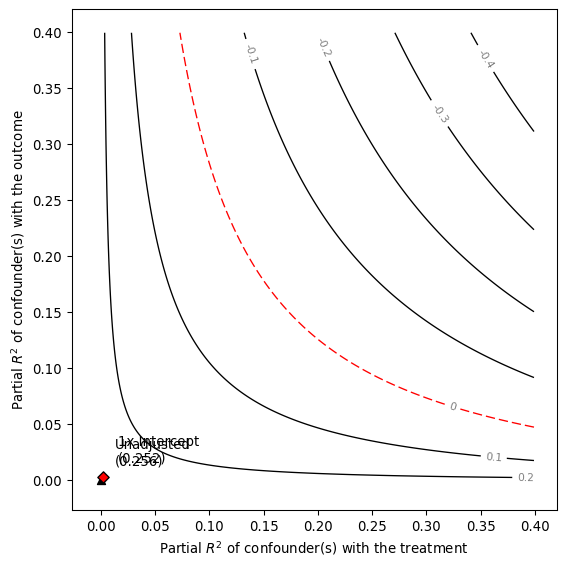

In [36]:
# We need to double check why the function does not allow to run withour the benchmark_covariates argument
dml_darfur_sensitivity = smkr.Sensemakr(dml_darfur_model_rf, "resD_rf", benchmark_covariates = "Intercept")
dml_darfur_sensitivity.summary()

# Make a contour plot for the estimate
dml_darfur_sensitivity.plot()